In [3]:
import numpy as np
import scipy.linalg
import scipy.io
from scipy.interpolate import griddata
%matplotlib inline

def trans_cov(dat, cov, mean=np.array([[0],[0]])):
    evals, evecs = scipy.linalg.eigh(cov)
    c = np.dot(evecs, np.diag(np.sqrt(evals)))
    res = np.dot(c,dat)
    if not np.allclose(np.round(np.cov(res)), cov):
        print(np.cov(res))
    res = res + mean
    assert np.allclose(np.round(np.mean(res, axis=1)), mean.T[0])
    
    return res

In [4]:
dats = [
            [trans_cov(np.random.randn(2, 200), np.eye(2)),
             trans_cov(np.random.randn(2, 200), np.eye(2), np.array([[3],[0]]))],
    
            [trans_cov(np.random.randn(2, 200), np.array([[4,3],[3,4]]), np.array([[-1],[0]])),
             trans_cov(np.random.randn(2, 200), np.array([[4,3],[3,4]]), np.array([[1],[0]]))],
    
            [trans_cov(np.random.randn(2, 200), np.array([[3,1],[1,2]])),
             trans_cov(np.random.randn(2, 200), np.array([[7,-3],[-3,4]]), np.array([[3],[0]]))]
        ]

[[ 4.07451574  2.59838977]
 [ 2.59838977  3.11604588]]
[[ 3.29306939  1.51159889]
 [ 1.51159889  2.54438721]]
[[ 7.07738125 -3.27646624]
 [-3.27646624  4.77276378]]


In [5]:
dats.append([scipy.io.loadmat("assign2.mat")["a1"], scipy.io.loadmat("assign2.mat")["b1"]])

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


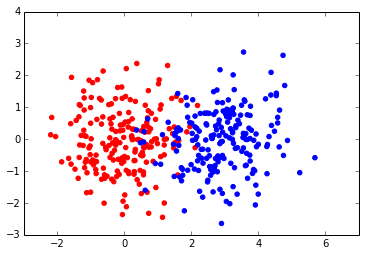

In [7]:
dat = dats[3]
fig = plt.figure()
plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.show()

In [8]:
def med(c1, c2):
    """Create an med function"""
    z1 = np.mean(c1, axis=1)
    z2 = np.mean(c2, axis=1)
    def f(x):
        return -np.dot(z1,x) + 0.5*np.dot(z1.T,z1) < -np.dot(z2,x) + 0.5*np.dot(z2.T,z2)
    return f

In [9]:
from numpy.linalg import norm, inv

def map_class(c1, c2):
    e1 = np.cov(c1)
    e2 = np.cov(c2)
    u1 = np.mean(c1, axis=1)
    u2 = np.mean(c2, axis=1)
    
    def f(x):
        # how do I vectorize this?
        return np.log(np.sqrt(norm(e2))/np.sqrt(norm(e1))) \
               -0.5*np.dot(np.dot((x - u1),inv(e1)),(x - u1).T) \
               +0.5*np.dot(np.dot((x - u2),inv(e2)),(x - u2).T) \
                < 0
    return f

In [10]:
def ged(c1, c2):
    s1 = inv(np.cov(c1))
    s2 = inv(np.cov(c2))
    u1 = np.mean(c1, axis=1)
    u2 = np.mean(c2, axis=1)
    
    def f(x):
        return np.sqrt(np.dot(np.dot((x - u1),s1),(x - u1).T)) > \
               np.sqrt(np.dot(np.dot((x - u2),s2),(x - u2).T)) 
        
    return f

In [11]:
def knn(c1, c2, k, offset=5):
    # initiaslise with all the points from each class
    zero_shape = (c1.shape[0], c1.shape[1]*2)
    c1_res = np.zeros(zero_shape)
    c1_count = 0
    c2_res = np.zeros(zero_shape)
    c2_count = 0
    c_all = np.concatenate((c1[:, offset:], c2[:, offset:]), axis=1)
    err_count = 0

    # because numpy nditer is psychotic
    for c_ind in xrange(c_all.shape[1]):
        val = c_all[:, c_ind]
        # find the nearest K neighbours
        ind = np.argpartition(norm(c_all.T - val, axis=1), k+1)[:k+1][1:k+1]
        
        # class the point where the majority of the neighbours are
        sort_res = 0
        for ix in ind:
            if ix < c1.shape[1]:
                sort_res += 1
            else:
                sort_res -= 1

        if sort_res > 0:
            c1_res[:, c1_count] = val
            c1_count += 1
            
            if c_ind > c1.shape[1]:
                err_count += 1
        else:
            c2_res[:, c2_count] = val
            c2_count += 1
            
            if c_ind <= c1.shape[1]:
                err_count += 1

    assert c1_count + c2_count == c1.shape[1] + c2.shape[1] - 2*offset
    return (c1_res[:, :c1_count], c2_res[:, :c2_count], err_count)

In [13]:
funcs = [med, ged, (knn, 1), (knn, 3), (knn, 5)]
res = [[], [], [], [], []]

def get_err(funct, dat1, dat2, offset=5):
    # get the function, calculate and return the error
    dat_length = dat1.shape[1] + dat2.shape[1]
    if type(funct) is tuple:
        res = funct[0](dat1, dat2, funct[1], offset)
        return float(res[2]) / float(dat_length)
    else:
        func = funct(dat1[:, :offset], dat2[:, :offset])
        tot_err = 0

        if funct == med:
            res = func(dat1[:, offset:])
            tot_err += np.where(res == False)[0].shape[0]
            res = func(dat2[:, offset:])
            tot_err += np.where(res == True)[0].shape[0]

        elif funct == ged:
            res = []
            for dat in list(dat1.T):
                res.append(func(dat))
            a_res = np.array(res, dtype=np.bool)
            tot_err += np.where(a_res == False)[0].shape[0]
            res = []
            for dat in list(dat2.T):
                res.append(func(dat))
            a_res = np.array(a_res, dtype=np.bool)
            tot_err += np.where(res == True)[0].shape[0]

        return float(tot_err) / float(dat_length)


for f_i, funct in enumerate(funcs):
    for dat in dats:
        dat1 = dat[0]
        dat2 = dat[1]
        for x_i in list(np.linspace(5, 200, 40)):
            # get the training data from the classification data
            res[f_i].append(get_err(funct, dat1, dat2))
            dat1 = np.roll(dat1, 5, axis=1)
            dat2 = np.roll(dat2, 5, axis=1)

# get the means and variances for each classification method
final_mean = np.mean(res, axis=1)
final_var = np.var(res, axis=1)    

In [19]:
final_mean = np.mean(res, axis=1)
final_var = np.var(res, axis=1) 

array([ 0.01831726,  0.01224589,  0.00735123,  0.00394413,  0.00374027])

In [29]:
res = [[], [], [], [], []]

# jack-knife
for f_i, funct in enumerate(funcs):
    for dat in dats:
        dat1 = dat[0]
        dat2 = dat[1]

        for offset in xrange(5, 195):
            res[f_i].append(get_err(funct, dat1, dat2, offset))
            
p_err_final = 1/400 * np.sum(res, axis=1)
# wtf, how do I avoid the singular matrix problem for the GED covariance? Can I just set the minimum xrange to 3?
# what about KNN? Can I limit that to 5 and 195?